# **NetMD**

This notebook illustrates the **NetMD workflow**, demonstrating how to process raw data or analyze saved results from a prior NetMD run, thus enabling observation of the tool's inner workings and facilitating further custom analysis. 

As a case study, this example utilizes eight replicas from targeted molecular dynamics simulations of glucose transporter 1 (**GLUT1**) wild type.

## Import Dependecies 🛠️

In [ ]:
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import plotly.graph_objects as go
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

from tslearn.metrics import dtw_path

from netmd.utils import extract_contacts, compare_contact_frequencies, moving_average
from netmd.embeddings import g2v_fit_transform, iterative_pruning
from netmd.dataLoader import crawl_replica_files
from netmd.clustering import compute_dtwmatrix

from tslearn.barycenters import dtw_barycenter_averaging

import ruptures as rpt
import networkx as nx
import pandas as pd
import pickle as pk
import numpy as np
import random

## Load data 📦

Load either raw contact data or files generated from a previous NetMD run. You will need:

* **List of graphs** with dimensions R×F (R = number of replicas, F = number of frames),
* **Metadata** DataFrame containing indexing information for the graphs, and
* **Entropy** DataFrame with the computed entropy for each contact across all frames and all replicas.

### Load raw files

In [2]:
graphs, meta_data, entropy_df = crawl_replica_files("./GLUT1_WT", "Full", features_data=pd.DataFrame(), verbose=True)

print(f"\nTotal number of graphs: {len(graphs)}")
print(f"Total number of replicas: {len(meta_data['Rep'].unique())}")
print(f"Total number of edges (entropy): {entropy_df.shape[0]}")


Loading data from FullReplica9_WT.tsv

         Frame  Res1  Res2
0            0   320   324
1            0   223   231
2            0   137   391
3            0   252   255
4            0   237   240
...        ...   ...   ...
2264714    499   144   234
2264719    499   216   233
2264725    499    37   108
2264726    499    75    79
2264727    499   226   227

[789540 rows x 3 columns]


Loading data from FullReplica5_WT.tsv

         Frame  Res1  Res2
0            0   105   175
1            0   252   255
2            0   211   214
3            0   203   234
4            0   212   236
...        ...   ...   ...
2215651    485    22   282
2215659    485    25   282
2215662    485    28   282
2215664    485    40    41
2215665    485   316   320

[770508 rows x 3 columns]


Loading data from FullReplica8_WT.tsv

         Frame  Res1  Res2
0            0   212   236
1            0   320   324
2            0   252   255
3            0   203   234
5            0   291   350
...        ...

#### Save Graphs, Entropy and Metadata 

Save the graphs, the entropy dataframe for all edges, and their identifying metadata in both pickle and tab-separated value formats.

In [ ]:
with open('./GLUT1_WT/graphs_emb.pkl', 'wb') as f:
    pk.dump(graphs, f)

entropy_df.to_csv('./GLUT1_WT/entropy_df.tsv', sep='\t')
meta_data.to_csv('./GLUT1_WT/meta_data.tsv', sep='\t', index=False)

print(f"Saved the graphs, entropy and metadata to ./GLUT1_WT")

## Entropy 🌡️

**Entropy** is calculated for each residue-residue interaction across simulation frames to quantify their variability, providing a quantitative measure of how interaction fluctuates over time; this allows to identify and exclude two categories of interactions: 

* **Rare interaction**: contacts with low frequency and high variability, which may arise from random noise in the simulation; 
* **Highly conserved regions**: consistently present across all frames and replicas, which, while important for structural stability, contribute minimally to distinguishing between frames or replicas. 

A threshold is selected based on its ability to balance the inclusion of dynamic interactions while filtering out noise: the choice of this value is not absolute and can be adjusted to emphasize specific interaction patterns. **Lower thresholds** may capture more interactions, potentially increasing sensitivity to subtle variations, instead **higher thresholds** provide stricter criteria, focusing only on the most dynamic interactions

The entropy \( H \) is defined as:

$$
H = -p\log_2(p) - (1-p) log_2 (1-p)
$$

where *p* represents the mean contact frequency across all frames and replicas for a given interaction.

In [11]:
threshold = 0.1 # the threshold for filtering edges based on entropy across all frames and all replicas

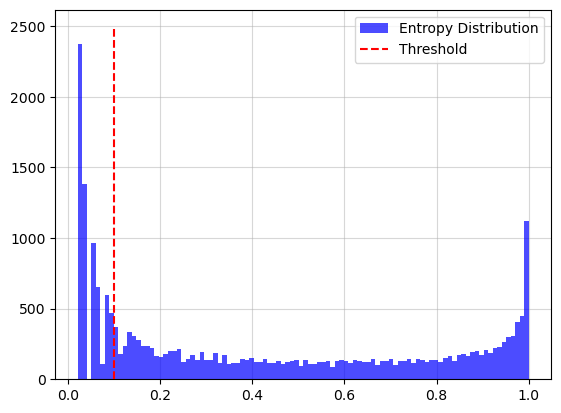

In [12]:
plt.hist(entropy_df.values.ravel()[entropy_df.values.ravel()>0.], bins=100, color='blue', alpha=0.7, zorder=2, label='Entropy Distribution')
plt.grid(which='major', zorder=-1.0, alpha=0.5)
plt.vlines(threshold, ymin=0, ymax=plt.ylim()[1], color='red', linestyle='--', label='Threshold', zorder=3)
plt.legend()
plt.show()

In [13]:
# Filter edges with entropy greater than a certain threshold
# This threshold can be adjusted based on the specific analysis needs
print(f"Threshold for entropy: {threshold}")
edge_list = list(entropy_df.T.loc[:,(entropy_df.T.fillna(0) > threshold).all(axis=0)].columns)
print(f"Edges that have an entropy > {threshold} across all time frames: {len(edge_list)}")

# Create subgraphs for each graph based on the filtered edge list
subgraphs = [nx.convert_node_labels_to_integers(g.edge_subgraph(edge_list), first_label=0, ordering='default') for g in graphs]

Threshold for entropy: 0.1
Edges that have an entropy > 0.1 across all time frames: 1472


Check the reduction in the number of edges after applying the entropy filter.

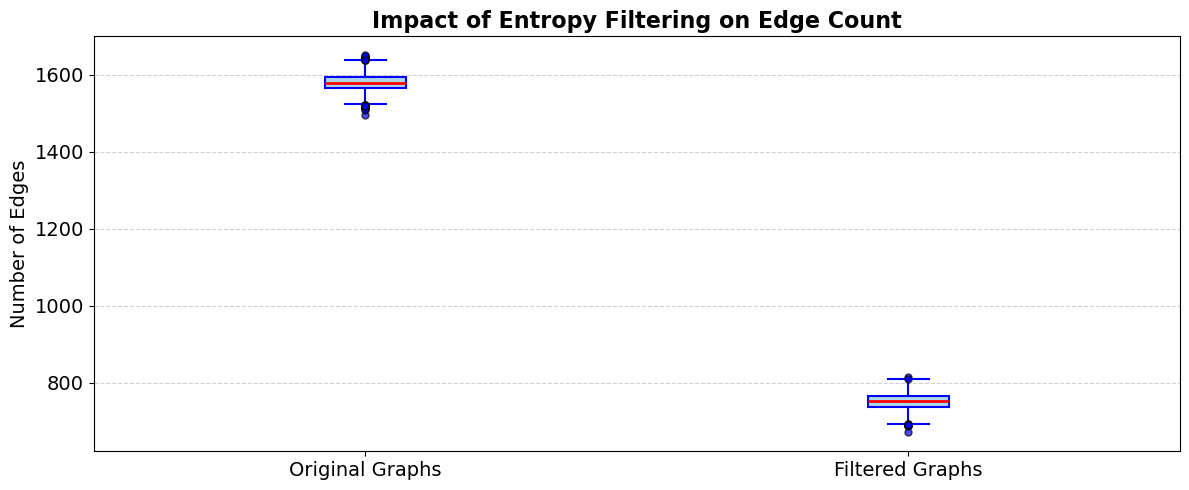

In [14]:
subgraph_edges = []
for i,g in enumerate(subgraphs):
    subgraph_edges.append(subgraphs[i].number_of_edges())

graph_edges = []
for i,g in enumerate(graphs):
    graph_edges.append(graphs[i].number_of_edges())

# Creating the plot
plt.figure(figsize=(12, 5))
plt.boxplot(
    [graph_edges, subgraph_edges],
    tick_labels=["Original Graphs", "Filtered Graphs"],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue', linewidth=1.5),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(markerfacecolor='blue', marker='o', markersize=5, alpha=0.7)
)

# Adding title and labels
plt.title("Impact of Entropy Filtering on Edge Count", fontsize=16, fontweight='bold')
plt.ylabel("Number of Edges", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adding grid
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

## Embedding 🌐

**Graph2Vec**, implemented in the [Karateclub](https://github.com/benedekrozemberczki/karateclub) library, is used to generate embeddings for the graphs. The result obtained is a time series of real-valued vectors.

In [15]:
# Shuffle the data and metadata
meta_data.reset_index(drop=True, inplace=True)
meta_data = meta_data.sample(frac=1, random_state=42)
subgraphs_shuffled = [subgraphs[i] for i in meta_data.index]

# Embedding the subgraphs using Graph2Vec
subgraphs_emb = g2v_fit_transform({'use_node_attribute': "feature", 'workers':1, 
                            'seed':42, 'down_sampling':0., 'epochs':10, 
                            'dimensions':16, 'wl_iterations':3, "learning_rate" : 0.025,
                            "min_count" : 5, "erase_base_features" : False},
                            subgraphs_shuffled)

print(f"Shape of the embeddings: {subgraphs_emb.shape}")


# Reorder the embeddings to match the original graphs
meta_data = meta_data.reset_index(drop=True).sort_values(['Rep', 'Frame'])

subgraphs_emb = subgraphs_emb[meta_data.index]

Shape of the embeddings: (3937, 16)


## Embedding Visualization 📈

To facilitate the **visualization of the embedding matrix**, dimensionality reduction techniques are applied: 
* **Principal Component Analysis (PCA)** retains 90% of the variance to reduce the dimensionality while preserving the most significant features of the data; 
* **Spectral Embedding** is used to project the data into a reduced dimensional space based on the graph’s connectivity structure.


The plots for the GLUT1 example data highlight two key aspects: they demonstrate time orientation preservation within the embedding space, indicating that the temporal sequence of the simulations is maintained, and they show the convergence of data points during the glucose release phase, the last phase of the MD, which was specifically modeled using Supervised Molecular Dynamics (SuMD), a technique employing a user-defined collective variable to bias the simulation towards a target state.

In [16]:
def dim_reduction(n_dimensions=2, n_jobs=1):
    
    dim_reduction_pipeline = Pipeline([
        ('PCA', PCA(n_components=0.9)),
        ("DimensionalityReduction", SpectralEmbedding(n_components=n_dimensions, n_jobs=n_jobs)),
    ])
    
    return dim_reduction_pipeline

### 2D

In [17]:
reduced_emb = dim_reduction(n_dimensions=2, n_jobs=-1).fit_transform(subgraphs_emb)

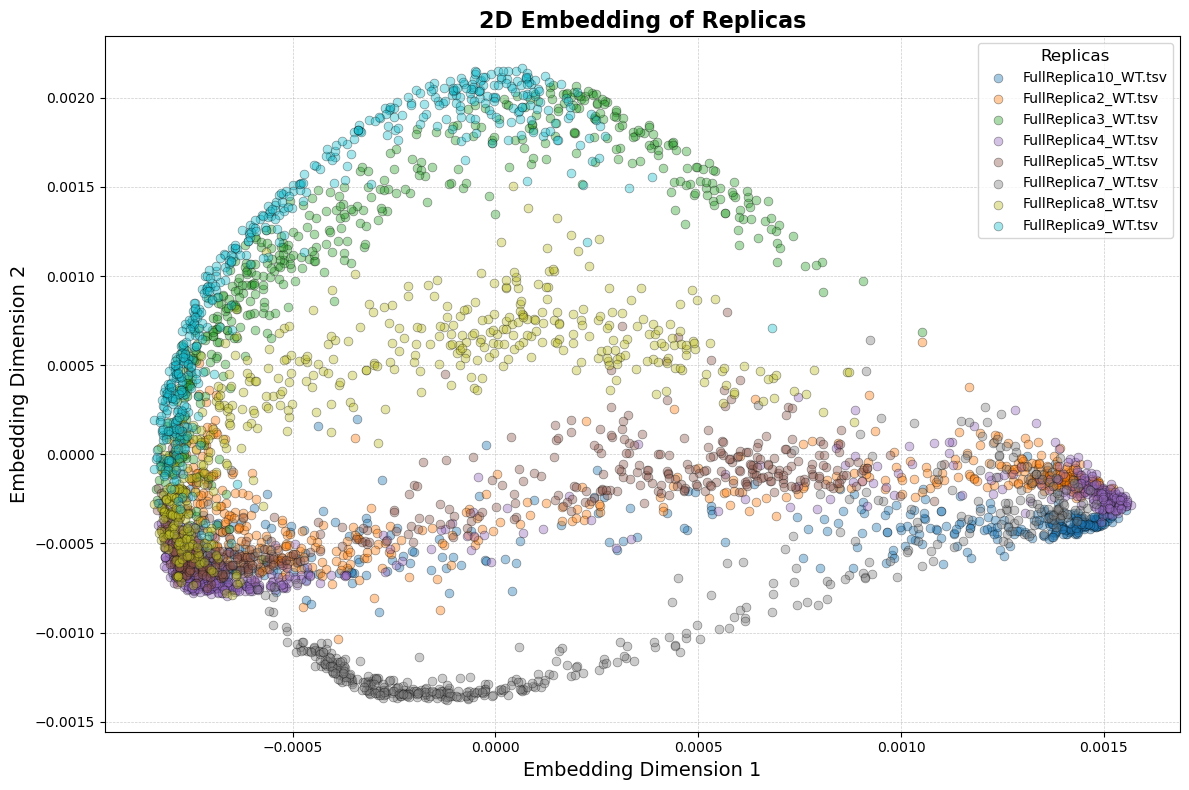

In [18]:
colors = plt.cm.tab10(np.linspace(0, 1, len(meta_data['Rep'].unique())))
plt.figure(figsize=(12, 8))

for color, replica in zip(colors, meta_data['Rep'].unique()):
    
    mask = meta_data['Rep'] == replica
    
    plt.scatter(
        reduced_emb[mask, 0],
        reduced_emb[mask, 1],
        alpha=0.4,
        s=40,
        label=(replica.split('/')[-1]),  # Simulating meaningful label extraction
        color=color,
        edgecolor="black",
        linewidths=0.5
    )

# Title and labels
plt.title("2D Embedding of Replicas", fontsize=16, fontweight='bold')
plt.xlabel("Embedding Dimension 1", fontsize=14)
plt.ylabel("Embedding Dimension 2", fontsize=14)

# Legend
plt.legend(title="Replicas", fontsize=10, title_fontsize=12, frameon=True)

# Grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

# Show the plot
plt.tight_layout()

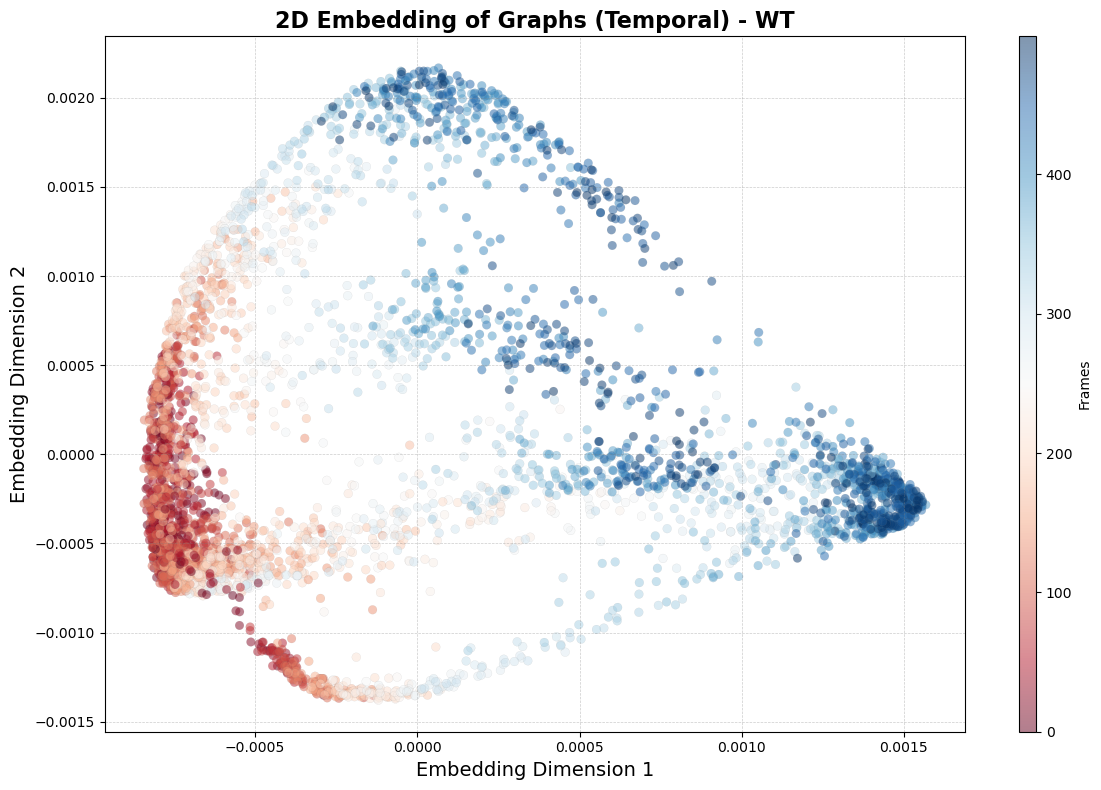

In [20]:
# Beautified Plot with Color Mapping
plt.figure(figsize=(12, 8))

for replica in meta_data['Rep'].unique():
    
    mask_meta = meta_data['Rep'] == replica
    
    plt.scatter(
        reduced_emb[mask_meta, 0],
        reduced_emb[mask_meta, 1],
        c=meta_data[mask_meta]['Frame'],  # Example for color mapping
        cmap="RdBu",
        marker='o',
        alpha=0.5,
        s=40,
        label=f'{replica.split("/")[-1]}',
        edgecolor="grey",
        linewidths=0.1
    )

# Adding a colorbar
plt.colorbar(label="Frames", orientation="vertical", aspect=40)

# Adding title and axis labels
plt.title("2D Embedding of Graphs (Temporal) - WT", fontsize=16, fontweight='bold')
plt.xlabel("Embedding Dimension 1", fontsize=14)
plt.ylabel("Embedding Dimension 2", fontsize=14)

# Legend
# Grid and layout adjustments
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()

### 3D

In [21]:
reduced_emb = dim_reduction(n_dimensions=3, n_jobs=-1).fit_transform(subgraphs_emb)

In [29]:
replicas = meta_data['Rep'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(replicas)))  # or use 'tab20' for more

# Plot each replica as a separate trace
fig = go.Figure()

for i, replica in enumerate(replicas):
    idx = meta_data['Rep'] == replica
    color_rgb = f'rgb({colors[i][0]*255:.0f},{colors[i][1]*255:.0f},{colors[i][2]*255:.0f})'
    
    fig.add_trace(go.Scatter3d(
        x=reduced_emb[idx, 0],
        y=reduced_emb[idx, 1],
        z=reduced_emb[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=color_rgb,
            opacity=0.4,
        ),
        name=replica  # legend label
    ))

# Set layout
fig.update_layout(
    title="3D Embedding of Graphs - Colored by Replica",
    scene=dict(
        xaxis_title="Embedding Dimension 1",
        yaxis_title="Embedding Dimension 2",
        zaxis_title="Embedding Dimension 3"
    ),
    width=1200,
    height=800,
    legend_title_text='Replica'
)

In [ ]:
fig = go.Figure()

replicas = meta_data['Rep'].unique()

for replica in replicas:
    # Get indices for the current replica
    mask = meta_data['Rep'] == replica
    replica_embeddings = reduced_emb[mask]
    replica_frames = meta_data['Frame'][mask]

    fig.add_trace(go.Scatter3d(
        x=replica_embeddings[:, 0],
        y=replica_embeddings[:, 1],
        z=replica_embeddings[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=replica_frames,  # Color by frame within this replica
            colorscale='RdBu',
            opacity=0.8,
            colorbar=dict(title="Frame") if replica == replicas[0] else None  # One colorbar only

        ),
        #name=str(replica)
    ))

fig.update_layout(
    title="3D Embedding Colored by Frame (Per Replica)",
    scene=dict(
        xaxis_title="Embedding Dimension 1",
        yaxis_title="Embedding Dimension 2",
        zaxis_title="Embedding Dimension 3"
    ),
    width=1200,
    height=800
)

fig.show()

## Phase Clustering 📊

GLUT1 traverse three known transport phases: glucose intake, major conformational rearrangement (outwar-to-inward-facing), and glucose release. Here it is illustrated how the embedding clearly preserve these 3 distinct transitions. 

In [30]:
clustering_model = KMeans(n_clusters=3, n_init=20)
clusters = clustering_model.fit_predict(subgraphs_emb)  # clustering on the embeddings complete spcace

### 2D

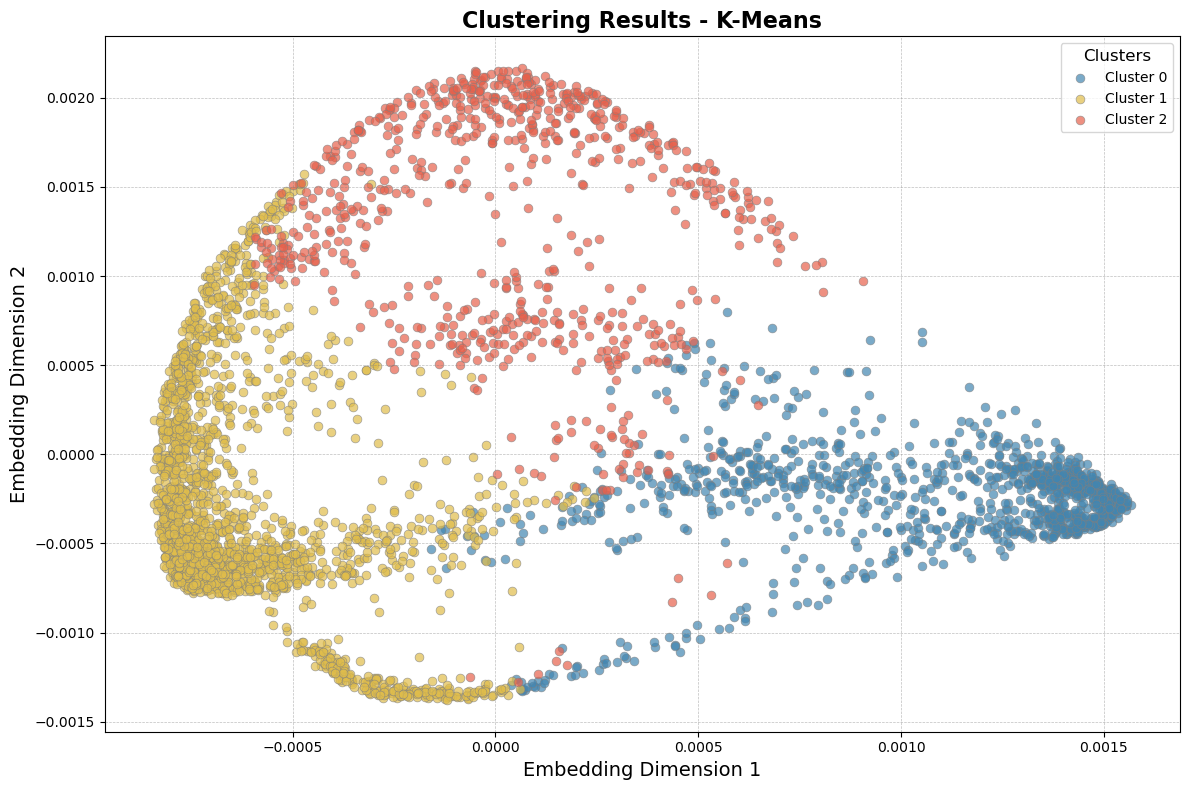

In [31]:
reduced_emb = dim_reduction(n_dimensions=2, n_jobs=-1).fit_transform(subgraphs_emb)

# Beautified Clustering Plot
plt.figure(figsize=(12, 8))

# Using a colormap to assign unique colors to each cluster
custom_colors = ["#4286B1", "#E0BD4B", "#E7614C"]  # Your custom colors

for color, label in zip(custom_colors, np.unique(clusters)):
    plt.scatter(
        reduced_emb[clusters == label, 0],
        reduced_emb[clusters == label, 1],
        marker='o',
        alpha=0.7,
        s=40,
        label=f'Cluster {label}',
        color=color,
        edgecolor='grey',
        linewidths=0.5
    )

# Title and axis labels
plt.title("Clustering Results - K-Means", fontsize=16, fontweight='bold')
plt.xlabel("Embedding Dimension 1", fontsize=14)
plt.ylabel("Embedding Dimension 2", fontsize=14)

# Legend
plt.legend(title="Clusters", fontsize=10, title_fontsize=12, loc="best", frameon=True)

# Grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Adjust layout and display
plt.tight_layout()

### 3D

In [45]:
reduced_emb = dim_reduction(n_dimensions=3, n_jobs=-1).fit_transform(subgraphs_emb)

fig = go.Figure()

unique_labels = np.unique(clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))  # You can also use 'tab10', 'Set3', etc.

for i, label in enumerate(unique_labels):
    idx = clusters == label
    custom_colors = ["#4286B1", "#E0BD4B", "#E7614C"]  # Your custom colors
    
    fig.add_trace(go.Scatter3d(
        x=reduced_emb[idx, 0],
        y=reduced_emb[idx, 1],
        z=reduced_emb[idx, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=custom_colors[i % len(custom_colors)],  # Cycle through custom colors
            opacity=0.4,
        ),
        name=f'Cluster {label}'
    ))

# Set layout
fig.update_layout(
    title="3D Embedding Colored by Cluster Label",
    scene=dict(
        xaxis_title="Embedding Dimension 1",
        yaxis_title="Embedding Dimension 2",
        zaxis_title="Embedding Dimension 3"
    ),
    width=1200,
    height=800,
    legend_title_text='Cluster'
)

fig.show()

## Alignment 🟰

**Dynamic Time Warping Barycenter Averaging (DBA)** is a method for computing the **barycenter** of multiple time series while considering their temporal alignment, effectively providing a central representation of the data. This method aims to find a central trajectory that minimizes the average distance between time series, while also considering their non-linear temporal shifts, making it particularly suitable for data with varying lengths and misalignments.

It is based on **Dynamic Time Warping (DTW)**, which allows the comparison of time series with varying lengths or temporal shifts.

The resulting barycenter captures the **consensus** representation of the embeddings across all replicas.

In [33]:
replicas_ts = [subgraphs_emb[meta_data['Rep'] == replica] for replica in meta_data['Rep'].unique()]
barycenter = dtw_barycenter_averaging(replicas_ts)

In [34]:
def distance_alignment(time_series, reference, type_dist=np.min):
    
    path, sim_score = dtw_path(time_series, reference)
    path = np.array(path).T
    ts_ids, ref_ids = path
    aligned_ts = time_series[ts_ids]
    aligned_ref = reference[ref_ids]
    per_frame_dist = ((aligned_ts-aligned_ref)**2).sum(axis=-1)**.5
    per_frame_dist =  pd.Series(per_frame_dist, index=ref_ids)

    return per_frame_dist.groupby(axis=0, level=0).apply(type_dist)

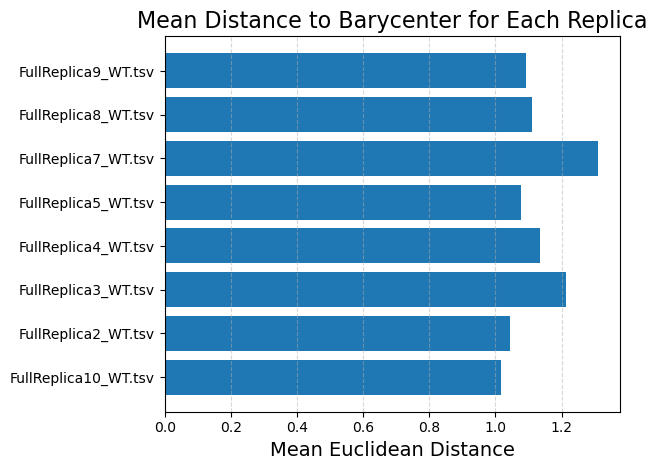

In [35]:
distances = np.array([distance_alignment(ts, barycenter, np.min) for ts in replicas_ts])

plt.barh(meta_data['Rep'].unique(), distances.mean(axis=1))
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlabel("Mean Euclidean Distance", fontsize=14)
plt.title("Mean Distance to Barycenter for Each Replica", fontsize=16)
plt.tight_layout()

### 2D

In [36]:
meta_data_bary = pd.concat([meta_data, pd.DataFrame({'Rep': ['barycenter']*len(barycenter), 'Frame': np.arange(0, len(barycenter))})])
reduced_emb = dim_reduction(n_dimensions=2, n_jobs=-1).fit_transform(np.concatenate([subgraphs_emb, barycenter]))

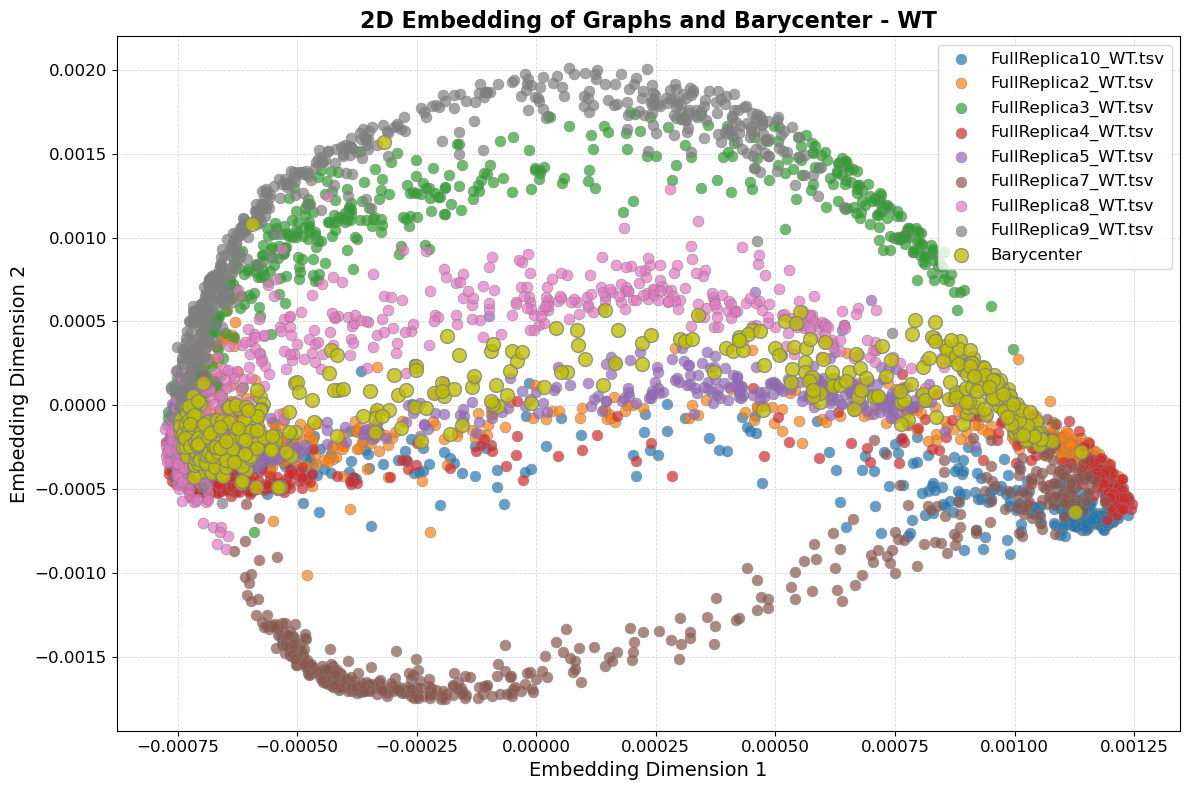

In [37]:
plt.figure(figsize=(12, 8))

# Plot each replica with color mapped by frames
for replica in meta_data_bary['Rep'].unique():
    if replica == 'barycenter':
        continue
    mask = meta_data_bary['Rep'] == replica
    scatter = plt.scatter(
        reduced_emb[mask, 0], 
        reduced_emb[mask, 1],
        marker='o',
        alpha=0.7,  # Lighter transparency for this case
        s=60,  # Larger marker size for better visibility
        label=f'{replica.strip().split("/")[-1]}',  # Add label for legend
        edgecolor="grey",  # Grey edges for all markers
        linewidths=0.5
    )

# Highlight the barycenter with a distinct style
plt.scatter(
    reduced_emb[meta_data_bary['Rep'] == 'barycenter', 0], 
    reduced_emb[meta_data_bary['Rep'] == 'barycenter', 1], 
    marker='o', 
    s=100,  # Larger size for the barycenter
    c='y',  # Distinct color for the barycenter
    edgecolor="grey",  # Edge color for clarity
    label="Barycenter",
    alpha=0.8  # Slight transparency to match the plot style
)

# Adding title and axis labels with increased font size and bold text
plt.title("2D Embedding of Graphs and Barycenter - WT", fontsize=16, fontweight='bold', color='black')
plt.xlabel("Embedding Dimension 1", fontsize=14, color='black')
plt.ylabel("Embedding Dimension 2", fontsize=14, color='black')

# Enhance ticks for better visibility
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

# Gridlines with light opacity for a cleaner look
plt.grid(True, color='gray', linestyle='--', linewidth=0.6, alpha=0.3)

# Add legend
plt.legend(loc='best', fontsize=12)

# Adjust layout for tight presentation
plt.tight_layout()

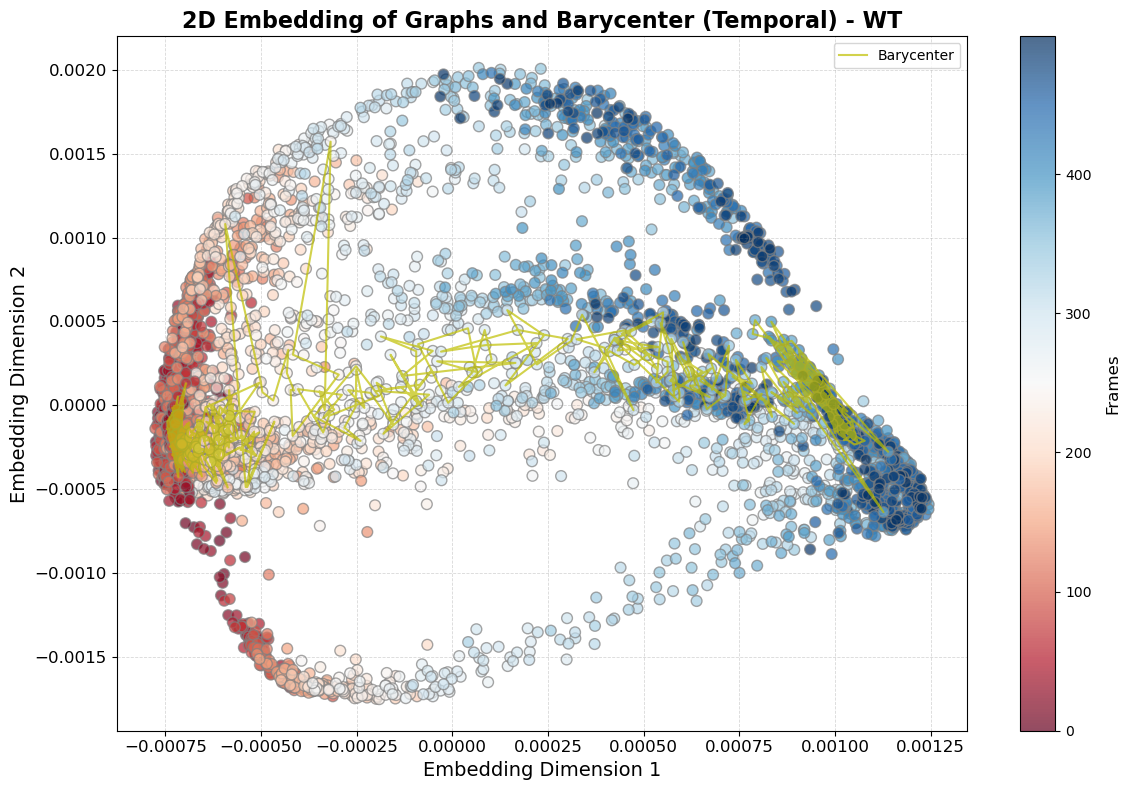

In [38]:
plt.figure(figsize=(12, 8))

# Plot each replica with color mapped by frames
for replica in meta_data_bary['Rep'].unique():
    mask = meta_data_bary['Rep'] == replica
    scatter = plt.scatter(
        reduced_emb[mask, 0], 
        reduced_emb[mask, 1],
        c=meta_data_bary[mask]['Frame'],
        cmap="RdBu",  # A nice perceptually uniform color map
        marker='o',
        alpha=0.7,  # More transparency
        s=60,  # Slightly larger marker size for better visibility
        edgecolor="grey",  # Black edge for better contrast
        #label=f'{replica.split("/")[-1]}'
    )

# Highlight the barycenter with a distinct style
plt.plot(
    reduced_emb[meta_data_bary['Rep'] == 'barycenter', 0], 
    reduced_emb[meta_data_bary['Rep'] == 'barycenter', 1], 
    #marker='o', 
    #s=100,  # Larger size for the barycenter
    c='y',  # Distinct color for the barycenter
    label="Barycenter",
    alpha=0.7
)

# Add a colorbar with a title
cbar = plt.colorbar(scatter, orientation='vertical')
cbar.set_label("Frames", fontsize=12, color="black", labelpad=10)
cbar.ax.tick_params(labelsize=10)

# Adding title and axis labels with increased font size and bold text
plt.title("2D Embedding of Graphs and Barycenter (Temporal) - WT", fontsize=16, fontweight='bold', color='black')
plt.xlabel("Embedding Dimension 1", fontsize=14, color='black')
plt.ylabel("Embedding Dimension 2", fontsize=14, color='black')

# Enhance ticks for better visibility
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

# Gridlines with light opacity for a cleaner look
plt.grid(True, color='gray', linestyle='--', linewidth=0.6, alpha=0.3)
plt.legend()

# Adjust layout for tight presentation
plt.tight_layout()

### 3D

In [39]:
meta_data_bary = pd.concat([meta_data, pd.DataFrame({'Rep': ['barycenter']*len(barycenter), 'Frame': np.arange(0, len(barycenter))})])
reduced_emb = dim_reduction(n_dimensions=3, n_jobs=-1).fit_transform(np.concatenate([subgraphs_emb, barycenter]))

In [43]:
fig = go.Figure()

# Use unique labels directly from ds_bary (no manual addition of 'barycenter')
all_ids = np.unique(meta_data_bary['Rep'])

# Assign colors dynamically
cmap = plt.get_cmap('tab10')
replica_colors = {rep: f'rgb{cmap(i % cmap.N)[:3]}' for i, rep in enumerate(all_ids)}

# Optional: force barycenter to be yellow if it's in the list
if 'barycenter' in replica_colors:
    replica_colors['barycenter'] = 'yellow'

# Plot each group
for replica in all_ids:
    mask = meta_data_bary['Rep'] == replica
    fig.add_trace(go.Scatter3d(
        x=reduced_emb[mask, 0],
        y=reduced_emb[mask, 1],
        z=reduced_emb[mask, 2],
        mode='markers',
        marker=dict(
            size=5 if replica != 'barycenter' else 6,
            opacity=0.4,
            color=replica_colors[replica],
        ),
        name=replica
    ))

# Layout
fig.update_layout(
    title="Interactive 3D Embedding of Graphs and Barycenter",
    scene=dict(
        xaxis_title="Embedding Dimension 1",
        yaxis_title="Embedding Dimension 2",
        zaxis_title="Embedding Dimension 3"
    ),
    width=1200,
    height=800
)

fig.show()

In [44]:
# Create the interactive 3D scatter plot
fig = go.Figure()

for replica in np.unique(meta_data_bary['Rep']):
    mask = meta_data_bary['Rep'] == replica
    color_vals = meta_data_bary[mask]['Frame']

    fig.add_trace(go.Scatter3d(
        x=reduced_emb[mask, 0],
        y=reduced_emb[mask, 1],
        z=reduced_emb[mask, 2],
        mode='markers',
        marker=dict(
            size=5 if replica == 'barycenter' else 5,
            color=color_vals,
            colorscale='Viridis' if replica == 'barycenter' else 'RdBu',
            opacity=0.8,
            colorbar=dict(title="Frame") if replica == 'barycenter' else None,
        ),
        name=replica
    ))

# Update layout
fig.update_layout(
    title="3D Embedding Colored by Frame (RdBu for Replicas, Viridis for Barycenter)",
    scene=dict(
        xaxis_title="Embedding Dimension 1",
        yaxis_title="Embedding Dimension 2",
        zaxis_title="Embedding Dimension 3"
    ),
    width=1400,
    height=800
)

fig.show()

## Iterative Pruning ✂️

Finally, we implemented an **iterative pruning** method to further refine the reference embedding. 

The main goal of this approach is to identify and eliminate replicas that deviate most significantly from the consensus, thereby ensuring that the final central representation accurately reflects the core dynamics in a robust manner. 

At each step, the barycenter was computed, and the replica with the **largest deviation** was removed until only the two closest replicas (both at the same distance from the barycenter) remained. This process allowed us to progressively **eliminate outliers** and minimize the influence of extreme or atypical conformational states.


In [46]:
replica_ranks_df, _ = iterative_pruning(replicas_ts, meta_data)
replica_ranks_df

,Rank,Barycenter_distance
FullReplica4_WT.tsv,0.0,0.630430
FullReplica10_WT.tsv,1.0,0.632957
FullReplica5_WT.tsv,2.0,0.837785
FullReplica2_WT.tsv,3.0,0.876091
FullReplica8_WT.tsv,4.0,0.995898
FullReplica9_WT.tsv,5.0,1.093046
FullReplica3_WT.tsv,6.0,1.037397
FullReplica7_WT.tsv,7.0,1.145724


## Hierarchical Clustering 🏅 

Finally, to explore the relationships between replicas, clusters are formed via **hierarchical clustering** based on the distances computed between each time series: the ward method is chosen, which aims at minimizing the total within-cluster variance.

The clustering, together with the distance from the barycenter, helps to highlight replicas that are a close approximation of the consensus of the whole experiment.

In [97]:
dtw_matrix_df = compute_dtwmatrix(replicas_ts, meta_data)
dtw_matrix_df

,FullReplica10_WT.tsv,FullReplica2_WT.tsv,FullReplica3_WT.tsv,FullReplica4_WT.tsv,FullReplica5_WT.tsv,FullReplica7_WT.tsv,FullReplica8_WT.tsv,FullReplica9_WT.tsv
FullReplica10_WT.tsv,0.000000,1.431954,1.654630,1.202588,1.300395,1.493586,1.437852,1.731079
FullReplica2_WT.tsv,1.431954,0.000000,1.686373,1.342850,1.282669,1.541971,1.542463,1.607167
FullReplica3_WT.tsv,1.654630,1.686373,0.000000,1.558536,1.567250,1.650924,1.283146,1.306800
FullReplica4_WT.tsv,1.202588,1.342850,1.558536,0.000000,1.385127,1.618257,1.403227,1.735661
FullReplica5_WT.tsv,1.300395,1.282669,1.567250,1.385127,0.000000,1.679778,1.316186,1.522518
FullReplica7_WT.tsv,1.493586,1.541971,1.650924,1.618257,1.679778,0.000000,1.631406,1.660028
FullReplica8_WT.tsv,1.437852,1.542463,1.283146,1.403227,1.316186,1.631406,0.000000,1.538279
FullReplica9_WT.tsv,1.731079,1.607167,1.306800,1.735661,1.522518,1.660028,1.538279,0.000000


<Figure size 1200x800 with 0 Axes>

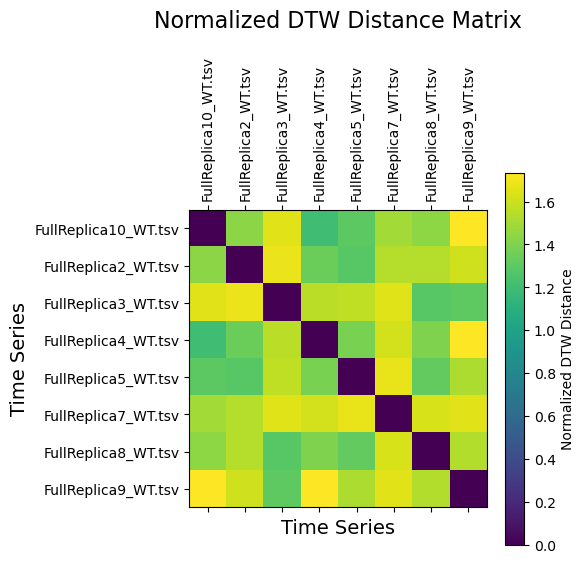

In [98]:
# Beautified DTW Matrix Visualization without Ticks
plt.figure(figsize=(12, 8))
plt.matshow(dtw_matrix_df, cmap="viridis")#, fignum=1)  # Using a perceptually uniform colormap
plt.colorbar(label="Normalized DTW Distance")  # Adding a label to the colorbar

# Adding labels and title
plt.title("Normalized DTW Distance Matrix", fontsize=16, pad=20)
plt.xlabel("Time Series", fontsize=14)
plt.ylabel("Time Series", fontsize=14)

# Add labels to axes (indices or column names of the distance matrix)
plt.xticks(ticks=np.arange(len(dtw_matrix_df.columns)), labels=dtw_matrix_df.columns, fontsize=10, rotation=90)
plt.yticks(ticks=np.arange(len(dtw_matrix_df.index)), labels=dtw_matrix_df.index, fontsize=10)

# Adding gridlines
plt.grid(False)

In [99]:
# Perform hierarchical clustering
linkage_matrix = linkage(squareform(dtw_matrix_df), method='ward',optimal_ordering=True)

# Create custom labels
custom_labels = [label.split("/")[-1] for label in dtw_matrix_df.index.values]

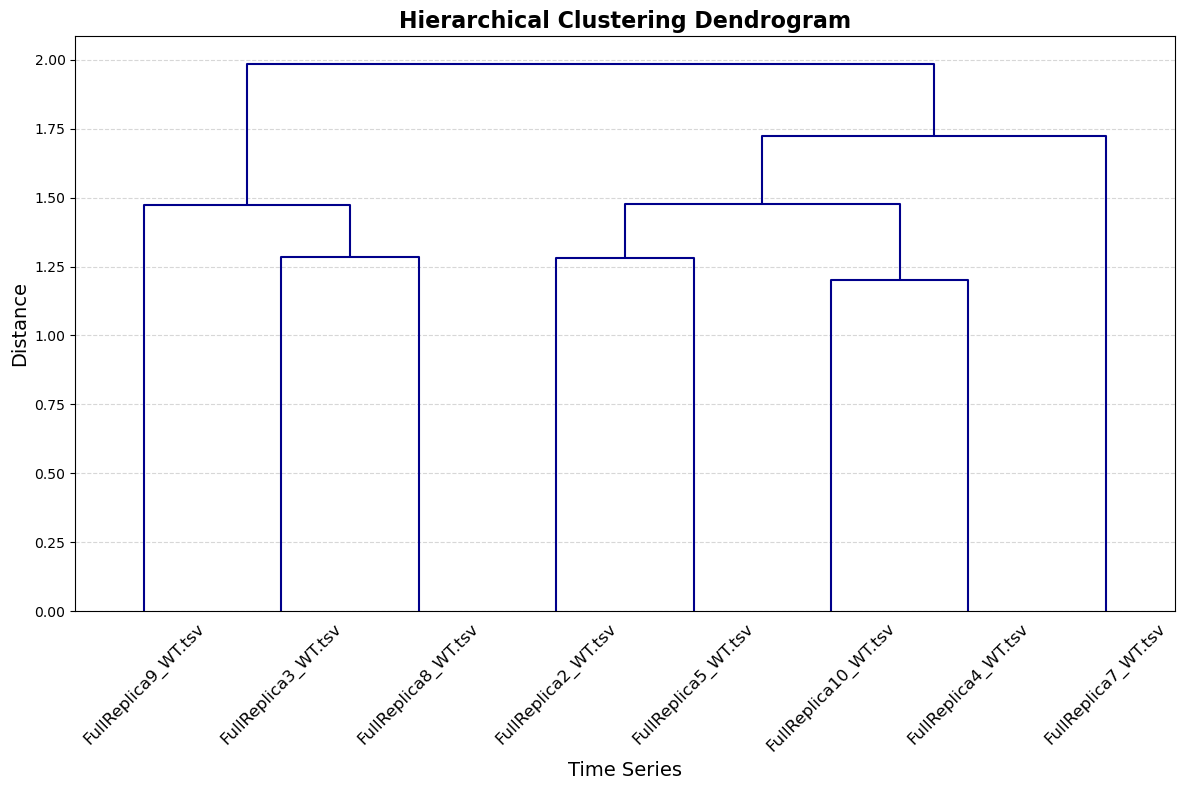

In [100]:
# Plot the dendrogram using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    labels=custom_labels,
    leaf_rotation=45,
    leaf_font_size=12,
    color_threshold=0,
    above_threshold_color='darkblue',
    ax=ax
)

# Add titles and labels with more styling
ax.set_title('Hierarchical Clustering Dendrogram', fontsize=16, fontweight='bold', color='black')
ax.set_xlabel('Time Series', fontsize=14, color='black')
ax.set_ylabel('Distance', fontsize=14, color='black')

# Add gridlines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

## Change point detection 🔎

To **detect anomalous dynamic behaviors** within individual replicas, we computed the pairwise Euclidean distance at each aligned time step (frame), comparing the **best variant replica** to a selected high-quality reference trajectory, namely the **best WT replica**. Then change points are detected via **PELT algorithm** that higlights points of interest.


This steps should be tailored to the specific analysis goals. (e.g. In this example, a smoothing window size of *51* was chosen to preserve sufficient temporal resolution around the conformational change of Glut1 occurring at frame *100*, ensuring the event remains detectable).


### Load WT data and select replicas to compare

In [49]:
with open(r'./GLUT1_R333Q/subgraphs_emb.pkl', "rb") as input_file:
    subgraphs_emb_333q = pk.load(input_file)

meta_data_333q = pd.read_csv('./GLUT1_R333Q/meta_data.tsv', sep='\t')


# Select the best replica for the WT (NetMD reports the replica 5 of the WT as one of the best)
best_replica_wt = subgraphs_emb[meta_data['Rep'] == 'FullReplica4_WT.tsv']
best_replica_333q = subgraphs_emb_333q[meta_data_333q['Rep'] == 'FullReplica5_r333q.tsv']

print(f"Shape of the best replica WT embeddings: {best_replica_wt.shape}")
print(f"Shape of the best replica 333Q embeddings: {best_replica_333q.shape}")

Shape of the best replica WT embeddings: (500, 16)
Shape of the best replica 333Q embeddings: (500, 16)


### Smoothed DTW time series distance from reference (WT Replica 8)

To reduce noise and enhance the interpretability of these temporal distance signals, we applied a centered moving average filter with an odd-sized sliding window: MD data can exhibit high-frequency noise due to small thermal fluctuations, but a moving average smooths out these short-term irregularities.

In [52]:
smoothing_window_size = 51  # Define the window size for smoothing

smoothed_333q = distance_alignment(best_replica_333q, best_replica_wt, np.median) # Function declared in the alignment section
smoothed_333q = (smoothed_333q - smoothed_333q.mean()) / (smoothed_333q.std())  # Standardize the time series

smoothed_333q = moving_average(smoothed_333q, window_size=smoothing_window_size)

In [53]:
fig = go.Figure()

# Add smoothed distances for each replica, excluding the reference

label = 'FullReplica4_333Q.tsv'

fig.add_trace(go.Scatter(
    y=smoothed_333q,
    mode='lines',
    name=label,
    opacity=0.7
))

# Customize layout
fig.update_layout(
    title="Smoothed DTW Distances to Reference (WT Replica5)",
    xaxis_title="Aligned Frame Index",
    yaxis_title="Distance to WT",
    font=dict(size=14),
    legend_title_text="Replica",
    template="plotly_white",
    height=500,
    width=1000
)

fig.show()

### Change points Detection with PELT

Pruned Exact Linear Time (PELT) algorithm is used to efficiently detect change points in a time series where the underlying statistical properties change. PELT aims to find a set of change points while minimizing the following objective:

$$ 

\min_{\{\tau_1, \tau_2, \ldots, \tau_m\}} \; \left [\sum_{i=0}^{m} \mathcal{C}(y_{\tau_i:\tau_i +1 } + \beta m) \right ]

$$

where: *i)* C is the cost for each segment, *ii)* β is the penalty term, *iii)* m is the number of change points.

The cost function used in this example is *'clinear'*, which models each segment as a piecewise linear function. As a result, it primarily detects changes in trend, such as shifts in slope or direction. The penalty used in this context is BIC.

In [54]:
model = 'clinear'
penality = np.log(smoothed_333q.shape[0])  

pelt = rpt.Pelt(model=model, min_size=11, jump=1).fit(smoothed_333q)
results = pelt.predict(pen=penality)
print(f"Detected change points: {results}")
print(f"Number of detected change points: {len(results) - 1}")
print(f"Penality: {penality}")

Detected change points: [58, 146, 205, 432, 500]
Number of detected change points: 4
Penality: 6.214608098422191


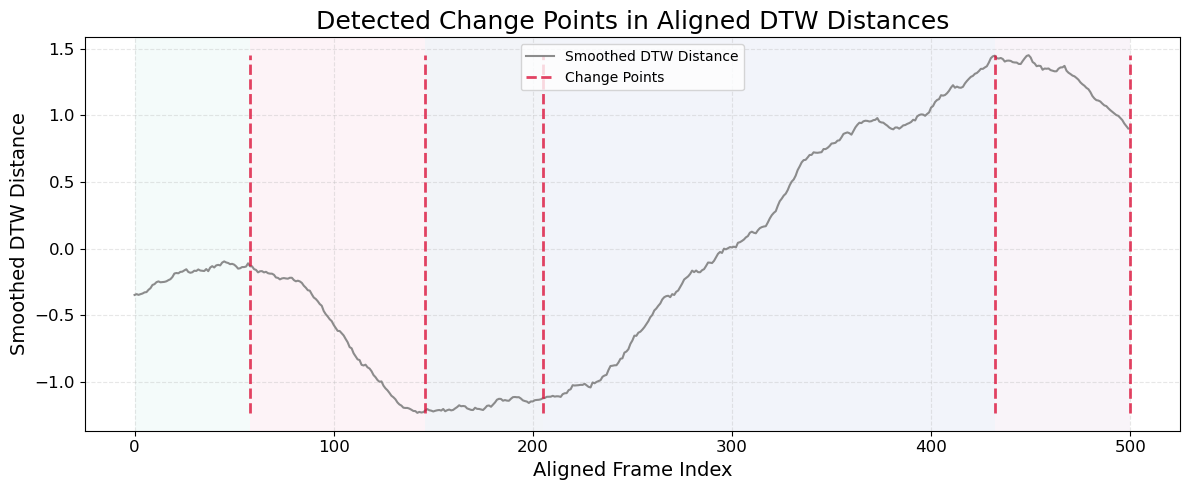

In [55]:
# Function to generate random pastel colors
def random_pastel_color(alpha=0.1):
    r, g, b = [random.uniform(0.5, 1.0) for _ in range(3)]
    return (r, g, b, alpha)

plt.figure(figsize=(12, 5))
ax = plt.gca()

# Draw background with random colors for each section
previous = 0
for x in [0] + results + [smoothed_333q.shape[0]]:  # last interval included
    color = random_pastel_color(alpha=0.1)
    ax.axvspan(previous, x, facecolor=color)
    previous = x

# Plot smoothed data
ax.plot(smoothed_333q, linewidth=1.5, alpha=0.9, label='Smoothed DTW Distance', color='grey')

# Stylish red dashed change-point lines
ax.vlines(x=results,
          ymin=smoothed_333q.min().min(),
          ymax=smoothed_333q.max().max(),
          color='crimson',
          linestyle='--',
          linewidth=2,
          alpha=0.8,
          label='Change Points')

# Aesthetic improvements
ax.set_title('Detected Change Points in Aligned DTW Distances', fontsize=18)
ax.set_xlabel('Aligned Frame Index', fontsize=14)
ax.set_ylabel('Smoothed DTW Distance', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=10)
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

### Change Point Contact Analysis

Based on the change-point previously identified, we measured the **ratio in contant frequencies** between the best WT replica and the best variant replica across the most significant time window. In particular we focused on the most extreme ratios: the higher the ratio the more a contact is conserved in the WT, conversely, a lower ratio indicates greater conservation of a contact in the variant. 

This allows us to **link the embedding space to the molecular ground truth of the MD simulation**. This leads to more precise and fast analysis of MD differences. 

In [57]:
frequencies_r333q = extract_contacts("./GLUT1_R333Q/FullReplica5_r333q.tsv", (results[2], results[-2]))
frequencies_wt = extract_contacts("./GLUT1_WT/FullReplica4_WT.tsv", (results[2], results[-2]))

common_df = compare_contact_frequencies(frequencies_wt, frequencies_r333q, 'WT', 'R333Q')

Interval of interest: 205–432 (inclusive)
Interval of interest: 205–432 (inclusive)
Exclusive contacts in WT:
    Res1  Res2  Frequency_wt
4      1   139      0.030702
10     1   232      0.004386
16     2   223      0.043860
17     2   224      0.021930
18     2   225      0.021930

Exclusive contacts in R333Q:
    Res1  Res2  Frequency_r333q
5      1   221         0.004386
34     3   226         0.004386
46     4   224         0.021930
47     4   225         0.004386
61     6   200         0.008772

Common contacts with odds ratio (WT/R333Q) - WT favored:
      Res1  Res2  Frequency_wt  Frequency_r333q  Odds_Ratio
763     78    90      0.596491         0.004386  135.969227
2006   248   257      0.460526         0.004386  104.976293
25       3   198      0.877193         0.008772   99.988715
397     33   415      0.385965         0.004386   87.980169
589     57   415      0.710526         0.008772   80.990881
458     38   109      0.328947         0.004386   74.983132
2005   248   256